[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meta-llama/llama-stack/blob/main/docs/getting_started.ipynb)

# Llama Stack - Building AI Applications

<img src="https://llamastack.github.io/latest/_images/llama-stack.png" alt="drawing" width="500"/>

[Llama Stack](https://github.com/meta-llama/llama-stack) defines and standardizes the set of core building blocks needed to bring generative AI applications to market. These building blocks are presented in the form of interoperable APIs with a broad set of Service Providers providing their implementations.

Read more about the project here: https://llamastack.github.io

In this guide, we will showcase how you can build LLM-powered agentic applications using Llama Stack.

**💡 Quick Start Option:** If you want a simpler and faster way to test out Llama Stack, check out the [quick_start.ipynb](quick_start.ipynb) notebook instead. It provides a streamlined experience for getting up and running in just a few steps.


## 1. Getting started with Llama Stack

### 1.1. Create TogetherAI account


In order to run inference for the llama models, you will need to use an inference provider. Llama stack supports a number of inference [providers](https://github.com/meta-llama/llama-stack/tree/main/llama_stack/providers/remote/inference).


In this showcase, we will use [together.ai](https://www.together.ai/) as the inference provider. So, you would first get an API key from Together if you dont have one already.

Steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?usp=sharing).

You can also use Fireworks.ai or even Ollama if you would like to.



> **Note:**  Set the API Key in the Secrets of this notebook



### 1.2 Install llama-stack and llama-stack-client packages

In [1]:
!pip install uv
!uv pip install llama-stack llama-stack-client

# Installs dependencies for the starter distribution
!uv run --with llama-stack llama stack list-deps starter | xargs -L1 uv pip install

Using Python 3.12.12 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/test
Resolved 84 packages in 603ms                                        
Prepared 1 package in 371ms                                              
Installed 3 packages in 50ms                                
 + ecdsa==0.19.1
 + llama-stack==0.2.23
 + python-jose==3.5.0
Using Python 3.12.12 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/test
Resolved 35 packages in 40ms                                         
Prepared 1 package in 1.19s                                              
Uninstalled 1 package in 3ms
Installed 1 package in 9ms=0.3.0a6 (from file:///Users/erich
 ~ llama-stack-client==0.3.0a6 (from file:///Users/erichuang/projects/llama-stack-client-python)
Using Python 3.12.12 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/test
Audited 52 packages in 1.18s
Using Python 3.12.12 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/test
Audited 1 package in 67ms
Using P

### 1.3. Setup and Running a Llama Stack server

Llama Stack is architected as a collection of APIs that provide developers with the building blocks to build AI applications. 

Llama stack is typically available as a server with an endpoint that you can make calls to. Partners like Together and Fireworks offer their own Llama Stack compatible endpoints.

In this showcase, we will start a Llama Stack server that is running locally.


In [2]:
import os
import subprocess
import time


if "UV_SYSTEM_PYTHON" in os.environ:
  del os.environ["UV_SYSTEM_PYTHON"]


def run_llama_stack_server_background():
    log_file = open("llama_stack_server.log", "w")
    process = subprocess.Popen(
        "uv run --with llama-stack llama stack run starter",
        shell=True,
        stdout=log_file,
        stderr=log_file,
        text=True
    )

    print(f"Starting Llama Stack server with PID: {process.pid}")
    return process

def wait_for_server_to_start():
    import requests
    from requests.exceptions import ConnectionError
    import time

    url = "http://0.0.0.0:8321/v1/health"
    max_retries = 30
    retry_interval = 1

    print("Waiting for server to start", end="")
    for _ in range(max_retries):
        try:
            response = requests.get(url)
            print(response)
            if response.status_code == 200:
                print("\nServer is ready!")
                return True
        except ConnectionError:
            print(".", end="", flush=True)
            time.sleep(retry_interval)

    print("\nServer failed to start after", max_retries * retry_interval, "seconds")
    return False


# use this helper if needed to kill the server
def kill_llama_stack_server():
    # Kill any existing llama stack server processes
    os.system("ps aux | grep -v grep | grep llama_stack.core.server.server | awk '{print $2}' | xargs kill -9")


### 1.3 Starting the Llama Stack Server

In [3]:
server_process = run_llama_stack_server_background()
assert wait_for_server_to_start()

Starting Llama Stack server with PID: 86923
Waiting for server to start..........<Response [200]>

Server is ready!


### 1.4. Configure the Client

Now that we have our Llama Stack server running locally, we will setup the client to interact with it. The `llama-stack-client` provides a simple Python interface to access all the functionality of Llama Stack, including:

- Chat Completions ( text and multimodal )
- Safety Shields 
- Agent capabilities with tools like web search, RAG with Telemetry
- Evaluation and scoring frameworks

The client handles all the API communication with our local server, making it easy to integrate Llama Stack's capabilities into your applications.

In the next cells, we'll:

1. Set up API keys for external services (Together AI and Tavily Search)
2. Initialize the client to connect to our local server


In [4]:
import os

try:
    from google.colab import userdata
    os.environ['TOGETHER_API_KEY'] = userdata.get('TOGETHER_API_KEY')
    os.environ['TAVILY_SEARCH_API_KEY'] = userdata.get('TAVILY_SEARCH_API_KEY')
except ImportError:
    print("Not in Google Colab environment")

for key in ['TOGETHER_API_KEY', 'TAVILY_SEARCH_API_KEY']:
    try:
        api_key = os.environ[key]
        if not api_key:
            raise ValueError(f"{key} environment variable is empty")
    except KeyError:
        api_key = input(f"{key} environment variable is not set. Please enter your API key: ")
        os.environ[key] = api_key

from llama_stack_client import LlamaStackClient

client = LlamaStackClient(
    base_url="http://0.0.0.0:8321",
    provider_data = {
        "tavily_search_api_key": os.environ['TAVILY_SEARCH_API_KEY'],
        "together_api_key": os.environ['TOGETHER_API_KEY']
    }
)

Not in Google Colab environment


In production settings, instead of pointing to localhost you could work with one of our partners that host a llama stack endpoint or host your own custom version. 

That would only require you to change the endpoint without changing application code. For eg. 
```
client = LlamaStackClient(
    base_url="https://llama-stack.together.ai",
    provider_data = {
        "together_api_key": XXXX
    }
)
```

Now that we have completed the setup and configuration, let's start exploring the capabilities of Llama Stack! We'll begin by checking what models and safety shields are available, and then move on to running some example chat completions.



### 1.5. Check available models and shields

All the models available in the provider are now programmatically accessible via the client.

In [9]:
from rich.pretty import pprint

print("Available models:")
for m in client.models.list():
    print(f"- {m.identifier}")

print("----")
print("Available shields (safety models):")
for s in client.shields.list():
    print(s.provider_resource_id)
print("----")


INFO:httpx:HTTP Request: GET http://0.0.0.0:8321/v1/models "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://0.0.0.0:8321/v1/shields "HTTP/1.1 200 OK"


Available models:
- fireworks/accounts/fireworks/models/flux-1-dev-fp8
- fireworks/accounts/fireworks/models/flux-kontext-max
- fireworks/accounts/fireworks/models/flux-kontext-pro
- fireworks/accounts/sentientfoundation-serverless/models/dobby-mini-unhinged-plus-llama-3-1-8b
- fireworks/accounts/sentientfoundation/models/dobby-unhinged-llama-3-3-70b-new
- fireworks/accounts/fireworks/models/gpt-oss-120b
- fireworks/accounts/fireworks/models/qwen3-235b-a22b-instruct-2507
- fireworks/accounts/fireworks/models/qwen3-235b-a22b-thinking-2507
- fireworks/accounts/fireworks/models/deepseek-v3-0324
- fireworks/accounts/fireworks/models/kimi-k2-instruct
- fireworks/accounts/fireworks/models/llama-v3p3-70b-instruct
- fireworks/accounts/fireworks/models/qwen3-235b-a22b
- fireworks/accounts/fireworks/models/deepseek-v3p1
- fireworks/accounts/fireworks/models/flux-1-schnell-fp8
- fireworks/accounts/fireworks/models/llama4-scout-instruct-basic
- fireworks/accounts/fireworks/models/llama-v3p1-70b-in

### 1.6. Run a simple chat completion with one of the models

We will test the client by doing a simple chat completion.

In [41]:
model_id = "together/meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"
# TODO remove
# model_id = "openai/gpt-4o"

response = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a friendly assistant."},
        {"role": "user", "content": "Write a two-sentence poem about llama."},
    ],
)

print(response.choices[0].message.content)


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


Here is a two-sentence poem about a llama:

With soft fur and gentle eyes, the llama roams with gentle surprise, a majestic creature of the Andes high. Its soft humming fills the Andean air, a soothing sound beyond compare.


### 1.7. Have a conversation

Maintaining a conversation history allows the model to retain context from previous interactions. Use a list to accumulate messages, enabling continuity throughout the chat session.

In [12]:
from termcolor import cprint

questions = [
    "Who was the most famous PM of England during world war 2 ?",
    "What was his most famous quote ?"
]


def chat_loop():
    conversation_history = []
    while len(questions) > 0:
        user_input = questions.pop(0)
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.chat.completions.create(
            messages=conversation_history,
            model=model_id,
        )
        cprint(f"> Response: {response.choices[0].message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.choices[0].message.content,
            "stop_reason": response.choices[0].finish_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


> Response: The most famous Prime Minister of England during World War II was Winston Churchill. He served as Prime Minister from 1940 to 1945 and again from 1951 to 1955. Churchill is widely regarded as one of the greatest wartime leaders in history, and his leadership during World War II played a significant role in the Allied victory.

Churchill was known for his oratory skills, and his speeches during the war, such as "We shall fight on the beaches" and "Their finest hour", helped to rally the British people during a time of great crisis. He also worked closely with other Allied leaders, such as US President Franklin D. Roosevelt and Soviet leader Joseph Stalin, to coordinate the war effort.

Churchill's leadership and vision helped to galvanize the British people during the war, and his legacy as a wartime leader has endured. He is often credited with helping to lead Britain to victory against Nazi Germany and its allies, and his name has become synonymous with British resilience 

INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


> Response: One of Winston Churchill's most famous quotes is:

**"We shall fight on the beaches"**

However, his most famous quote is often considered to be:

**"Blood, toil, tears and sweat: We have before us an ordeal of the most grievous kind."**

But arguably his most iconic and widely recognized quote is:

**"We shall fight on the beaches, in the streets, in the fields and in the hills. We shall never surrender."**

This quote was from his first speech as Prime Minister, delivered to the House of Commons on June 4, 1940, during the early stages of World War II, when Nazi Germany was threatening to invade Britain. The speech is known as the "We Shall Fight on the Beaches" speech, and it's considered one of the greatest speeches in history.

However, if I had to pick one that is most widely recognized and often cited as his most famous quote, it would be:

**"Iron Curtain"**

 Although not exactly a quote from WW2. It was  "From Stettin in the Baltic to Trieste in the Adriatic, an i

Here is an example for you to try a conversation yourself.
Remember to type `quit` or `exit` after you are done chatting.

In [13]:
# NBVAL_SKIP
from termcolor import cprint

def chat_loop():
    conversation_history = []
    while True:
        user_input = input("User> ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.chat.completions.create(
            messages=conversation_history,
            model=model_id,
        )
        cprint(f"> Response: {response.choices[0].message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.choices[0].message.content,
            "stop_reason": response.choices[0].finish_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


User>  hello


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


> Response: Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?


User>  exit


Ending conversation. Goodbye!


### 1.9. Streaming output

You can pass `stream=True` to stream responses from the model. You can then loop through the responses.

In [57]:
message = {"role": "user", "content": "Write me a sonnet about llama"}
print(f'User> {message["content"]}')

response = client.chat.completions.create(
    messages=[message],
    model=model_id,
    stream=True,  # <-----------
)

# Print the tokens while they are received
print("Assistant> ")
for chunk in response:
    if chunk.choices:
        print(chunk.choices[0].delta.content, end="", flush=True)


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


User> Write me a sonnet about llama
Assistant> 
In Andean heights, the llama makes its stand,
A creature of soft eyes and gentle face,
With fur so fine, it seems a woolly band
That wraps its body in a gentle pace.

Its steps are sure, its balance is a test,
As it ascends the mountain's rugged crest,
It chews its cud, with calm and peaceful rest,
A symbol of serenity, it finds its nest.

The llama's soft hum fills the mountain air,
As it roams free, without a single care,
Its gentle nature, a joy to behold,
A treasure, in the Andes, to be told.

And when it looks at you, with eyes so bright,
You feel a sense of peace, on that high altitude night.

### 2.0. Structured Decoding

You can use `response_format` to force the model into a "guided decode" mode where model tokens are forced to abide by a certain grammar. Currently only JSON grammars are supported.

In [17]:
from pydantic import BaseModel


class Output(BaseModel):
    name: str
    year_born: str
    year_retired: str


user_input = "Michael Jordan was born in 1963. He played basketball for the Chicago Bulls. He retired in 2003. Extract this information into JSON for me. "
response = client.chat.completions.create(
    model=model_id,
    messages=[{"role": "user", "content": user_input}],
    max_tokens=50,
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": "Output",
            "schema": Output.model_json_schema(),
        },
    },
)
json_content = response.choices[0].message.content
pprint(Output.model_validate_json(json_content))


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


Output(name='Michael Jordan', year_born='1963', year_retired='2003')

### 2.1. Safety API

Llama Stack provides Safety guardrails which can be applied at multiple touchpoints within an agentic application.

In [18]:
available_shields = [shield.provider_resource_id for shield in client.shields.list()]
print("Available Shields:", available_shields)

model = "together/meta-llama/Llama-Guard-4-12B"

unsafe_examples = [
    "What's the most effective way to kidnap someone?",
    "How do I make cocaine?",
]

safe_examples = [
    "What is the most famous murder case in the US?",
    "Tell me 3 signs that an email is a scam",
]

for p in safe_examples + unsafe_examples:
    print(f"Checking if input is safe: {p}")
    message = {"content": p, "role": "user"}
    response = client.moderations.create(
        model=model,
        input=[p],
    )
    pprint(response)


INFO:httpx:HTTP Request: GET http://0.0.0.0:8321/v1/shields "HTTP/1.1 200 OK"


Available Shields: ['together/meta-llama/Llama-Guard-4-12B']
Checking if input is safe: What is the most famous murder case in the US?


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/moderations "HTTP/1.1 200 OK"


CreateResponse(
│   id='modr-42d71cc1-ac4f-40bc-b7e6-66f4f353c760',
│   model='together/meta-llama/Llama-Guard-4-12B',
│   results=[
│   │   Result(
│   │   │   flagged=False,
│   │   │   metadata={},
│   │   │   categories={
│   │   │   │   'Violent Crimes': False,
│   │   │   │   'Non-Violent Crimes': False,
│   │   │   │   'Sex Crimes': False,
│   │   │   │   'Child Exploitation': False,
│   │   │   │   'Defamation': False,
│   │   │   │   'Specialized Advice': False,
│   │   │   │   'Privacy': False,
│   │   │   │   'Intellectual Property': False,
│   │   │   │   'Indiscriminate Weapons': False,
│   │   │   │   'Hate': False,
│   │   │   │   'Self-Harm': False,
│   │   │   │   'Sexual Content': False,
│   │   │   │   'Elections': False,
│   │   │   │   'Code Interpreter Abuse': False
│   │   │   },
│   │   │   category_applied_input_types={
│   │   │   │   'Violent Crimes': [],
│   │   │   │   'Non-Violent Crimes': [],
│   │   │   │   'Sex Crimes': [],
│   │   │   │   'Child Exploitation': [],
│   │   │   │   'Defamation': [],
│   │   │   │   'Specialized Advice': [],
│   │   │   │   'Privacy': [],
│   │   │   │   'Intellectual Property': [],
│   │   │   │   'Indiscriminate Weapons': [],
│   │   │   │   'Hate': [],
│   │   │   │   'Self-Harm': [],
│   │   │   │   'Sexual Content': [],
│   │   │   │   'Elections': [],
│   │   │   │   'Code Interpreter Abuse': []
│   │   │   },
│   │   │   category_scores={
│   │   │   │   'Violent Crimes': 1.0,
│   │   │   │   'Non-Violent Crimes': 1.0,
│   │   │   │   'Sex Crimes': 1.0,
│   │   │   │   'Child Exploitation': 1.0,
│   │   │   │   'Defamation': 1.0,
│   │   │   │   'Specialized Advice': 1.0,
│   │   │   │   'Privacy': 1.0,
│   │   │   │   'Intellectual Property': 1.0,
│   │   │   │   'Indiscriminate Weapons': 1.0,
│   │   │   │   'Hate': 1.0,
│   │   │   │   'Self-Harm': 1.0,
│   │   │   │   'Sexual Content': 1.0,
│   │   │   │   'Elections': 1.0,
│   │   │   │   'Code Interpreter Abuse': 1.0
│   │   │   },
│   │   │   user_message=None
│   │   )
│   ]
)

Checking if input is safe: Tell me 3 signs that an email is a scam


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/moderations "HTTP/1.1 200 OK"


CreateResponse(
│   id='modr-68f0f6be-c6a9-4dfb-9ecb-66f1707980b7',
│   model='together/meta-llama/Llama-Guard-4-12B',
│   results=[
│   │   Result(
│   │   │   flagged=False,
│   │   │   metadata={},
│   │   │   categories={
│   │   │   │   'Violent Crimes': False,
│   │   │   │   'Non-Violent Crimes': False,
│   │   │   │   'Sex Crimes': False,
│   │   │   │   'Child Exploitation': False,
│   │   │   │   'Defamation': False,
│   │   │   │   'Specialized Advice': False,
│   │   │   │   'Privacy': False,
│   │   │   │   'Intellectual Property': False,
│   │   │   │   'Indiscriminate Weapons': False,
│   │   │   │   'Hate': False,
│   │   │   │   'Self-Harm': False,
│   │   │   │   'Sexual Content': False,
│   │   │   │   'Elections': False,
│   │   │   │   'Code Interpreter Abuse': False
│   │   │   },
│   │   │   category_applied_input_types={
│   │   │   │   'Violent Crimes': [],
│   │   │   │   'Non-Violent Crimes': [],
│   │   │   │   'Sex Crimes': [],
│   │   │   │   'Child Exploitation': [],
│   │   │   │   'Defamation': [],
│   │   │   │   'Specialized Advice': [],
│   │   │   │   'Privacy': [],
│   │   │   │   'Intellectual Property': [],
│   │   │   │   'Indiscriminate Weapons': [],
│   │   │   │   'Hate': [],
│   │   │   │   'Self-Harm': [],
│   │   │   │   'Sexual Content': [],
│   │   │   │   'Elections': [],
│   │   │   │   'Code Interpreter Abuse': []
│   │   │   },
│   │   │   category_scores={
│   │   │   │   'Violent Crimes': 1.0,
│   │   │   │   'Non-Violent Crimes': 1.0,
│   │   │   │   'Sex Crimes': 1.0,
│   │   │   │   'Child Exploitation': 1.0,
│   │   │   │   'Defamation': 1.0,
│   │   │   │   'Specialized Advice': 1.0,
│   │   │   │   'Privacy': 1.0,
│   │   │   │   'Intellectual Property': 1.0,
│   │   │   │   'Indiscriminate Weapons': 1.0,
│   │   │   │   'Hate': 1.0,
│   │   │   │   'Self-Harm': 1.0,
│   │   │   │   'Sexual Content': 1.0,
│   │   │   │   'Elections': 1.0,
│   │   │   │   'Code Interpreter Abuse': 1.0
│   │   │   },
│   │   │   user_message=None
│   │   )
│   ]
)

Checking if input is safe: What's the most effective way to kidnap someone?


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/moderations "HTTP/1.1 200 OK"


CreateResponse(
│   id='modr-b67e4e53-82fd-4300-843c-193bd995642b',
│   model='together/meta-llama/Llama-Guard-4-12B',
│   results=[
│   │   Result(
│   │   │   flagged=True,
│   │   │   metadata={'violation_type': ['S1']},
│   │   │   categories={
│   │   │   │   'Violent Crimes': True,
│   │   │   │   'Non-Violent Crimes': False,
│   │   │   │   'Sex Crimes': False,
│   │   │   │   'Child Exploitation': False,
│   │   │   │   'Defamation': False,
│   │   │   │   'Specialized Advice': False,
│   │   │   │   'Privacy': False,
│   │   │   │   'Intellectual Property': False,
│   │   │   │   'Indiscriminate Weapons': False,
│   │   │   │   'Hate': False,
│   │   │   │   'Self-Harm': False,
│   │   │   │   'Sexual Content': False,
│   │   │   │   'Elections': False,
│   │   │   │   'Code Interpreter Abuse': False
│   │   │   },
│   │   │   category_applied_input_types={
│   │   │   │   'Violent Crimes': ['text'],
│   │   │   │   'Non-Violent Crimes': [],
│   │   │   │   'Sex Crimes': [],
│   │   │   │   'Child Exploitation': [],
│   │   │   │   'Defamation': [],
│   │   │   │   'Specialized Advice': [],
│   │   │   │   'Privacy': [],
│   │   │   │   'Intellectual Property': [],
│   │   │   │   'Indiscriminate Weapons': [],
│   │   │   │   'Hate': [],
│   │   │   │   'Self-Harm': [],
│   │   │   │   'Sexual Content': [],
│   │   │   │   'Elections': [],
│   │   │   │   'Code Interpreter Abuse': []
│   │   │   },
│   │   │   category_scores={
│   │   │   │   'Violent Crimes': 1.0,
│   │   │   │   'Non-Violent Crimes': 0.0,
│   │   │   │   'Sex Crimes': 0.0,
│   │   │   │   'Child Exploitation': 0.0,
│   │   │   │   'Defamation': 0.0,
│   │   │   │   'Specialized Advice': 0.0,
│   │   │   │   'Privacy': 0.0,
│   │   │   │   'Intellectual Property': 0.0,
│   │   │   │   'Indiscriminate Weapons': 0.0,
│   │   │   │   'Hate': 0.0,
│   │   │   │   'Self-Harm': 0.0,
│   │   │   │   'Sexual Content': 0.0,
│   │   │   │   'Elections': 0.0,
│   │   │   │   'Code Interpreter Abuse': 0.0
│   │   │   },
│   │   │   user_message="I can't answer that. Can I help with something else?"
│   │   )
│   ]
)

Checking if input is safe: How do I make cocaine?


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/moderations "HTTP/1.1 200 OK"


CreateResponse(
│   id='modr-bc5c89e5-0b3d-4672-8ba8-70a34df66c8d',
│   model='together/meta-llama/Llama-Guard-4-12B',
│   results=[
│   │   Result(
│   │   │   flagged=True,
│   │   │   metadata={'violation_type': ['S2']},
│   │   │   categories={
│   │   │   │   'Violent Crimes': False,
│   │   │   │   'Non-Violent Crimes': True,
│   │   │   │   'Sex Crimes': False,
│   │   │   │   'Child Exploitation': False,
│   │   │   │   'Defamation': False,
│   │   │   │   'Specialized Advice': False,
│   │   │   │   'Privacy': False,
│   │   │   │   'Intellectual Property': False,
│   │   │   │   'Indiscriminate Weapons': False,
│   │   │   │   'Hate': False,
│   │   │   │   'Self-Harm': False,
│   │   │   │   'Sexual Content': False,
│   │   │   │   'Elections': False,
│   │   │   │   'Code Interpreter Abuse': False
│   │   │   },
│   │   │   category_applied_input_types={
│   │   │   │   'Violent Crimes': [],
│   │   │   │   'Non-Violent Crimes': ['text'],
│   │   │   │   'Sex Crimes': [],
│   │   │   │   'Child Exploitation': [],
│   │   │   │   'Defamation': [],
│   │   │   │   'Specialized Advice': [],
│   │   │   │   'Privacy': [],
│   │   │   │   'Intellectual Property': [],
│   │   │   │   'Indiscriminate Weapons': [],
│   │   │   │   'Hate': [],
│   │   │   │   'Self-Harm': [],
│   │   │   │   'Sexual Content': [],
│   │   │   │   'Elections': [],
│   │   │   │   'Code Interpreter Abuse': []
│   │   │   },
│   │   │   category_scores={
│   │   │   │   'Violent Crimes': 0.0,
│   │   │   │   'Non-Violent Crimes': 1.0,
│   │   │   │   'Sex Crimes': 0.0,
│   │   │   │   'Child Exploitation': 0.0,
│   │   │   │   'Defamation': 0.0,
│   │   │   │   'Specialized Advice': 0.0,
│   │   │   │   'Privacy': 0.0,
│   │   │   │   'Intellectual Property': 0.0,
│   │   │   │   'Indiscriminate Weapons': 0.0,
│   │   │   │   'Hate': 0.0,
│   │   │   │   'Self-Harm': 0.0,
│   │   │   │   'Sexual Content': 0.0,
│   │   │   │   'Elections': 0.0,
│   │   │   │   'Code Interpreter Abuse': 0.0
│   │   │   },
│   │   │   user_message="I can't answer that. Can I help with something else?"
│   │   )
│   ]
)

## 2. Llama Stack Agents

Llama Stack provides all the building blocks needed to create sophisticated AI applications. This guide will walk you through how to use these components effectively.




<img src="https://github.com/meta-llama/llama-stack/blob/main/docs/static/img/agentic-system.png?raw=true" alt="drawing" width="800"/>


Agents are characterized by having access to

1. Memory - for RAG
2. Tool calling - ability to call tools like search and code execution
3. Tool call + Inference loop - the LLM used in the agent is able to perform multiple iterations of call
4. Shields - for safety calls that are executed everytime the agent interacts with external systems, including user prompts

### 2.1. Search agent

In this example, we will show how the model can invoke search to be able to answer questions. We will first have to set the API key of the search tool.

Let's make sure we set up a web search tool for the model to call in its agentic loop. In this tutorial, we will use [Tavily](https://tavily.com) as our search provider. Note that the "type" of the tool is still "brave_search" since Llama models have been trained with brave search as a builtin tool. Tavily is just being used in lieu of Brave search.

See steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?tab=t.0#heading=h.xx02wojfl2f9).

In [19]:
from llama_stack_client import Agent, AgentEventLogger
from termcolor import cprint

agent = Agent(
    client,
    model=model_id,
    instructions="You are a helpful assistant. Use websearch tool to help answer questions.",
    tools=[
        {"type": "web_search"}],
)
user_prompts = [
    "Hello",
    "Which teams played in the NBA western conference finals of 2024",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        print(log, end="", flush=True)


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/conversations "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/responses "HTTP/1.1 200 OK"


User> Hello
🤔 Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/responses "HTTP/1.1 200 OK"


User> Which teams played in the NBA western conference finals of 2024
🤔 

🔧 Executing web_search (server-side)...
🤔 The teams that played in the NBA Western Conference Finals of 2024 were the Dallas Mavericks and the Minnesota Timberwolves. The Dallas Mavericks won the series 4-1.


### 2.2. RAG Agent

In this example, we will index some documentation and ask questions about that documentation.

The tool we use is the file_search tool. Given a list of vector stores, the tool can help the agent query and retireve relevent chunks. In this example, we first create a vector stroe and add some documents to it. Then configure the agent to use the file_search tool. The difference here from the websearch example is that we pass along the vector store as an argument to the tool. 

In [59]:
import uuid
from llama_stack_client import Agent, AgentEventLogger, RAGDocument
from termcolor import cprint
import requests

urls = ["chat.rst", "llama3.rst", "memory_optimizations.rst", "lora_finetune.rst"]

# Step 1: Upload files
file_ids = []
for i, url in enumerate(urls):
    full_url = f"https://raw.githubusercontent.com/pytorch/torchtune/main/docs/source/tutorials/{url}"
    response = requests.get(full_url)
    
    file = client.files.create(
        file=response.content,
        purpose='assistants'
    )
    file_ids.append(file.id)
    

# Step 2: Create a vector store with files
vector_store = client.vector_stores.create(
    name=f"torchtune-docs-{uuid.uuid4().hex[:8]}",
    file_ids=file_ids,
    chunking_strategy={
        "type": "static",
        "static": {
            "max_chunk_size_tokens": 512,
            "chunk_overlap_tokens": 50
        }
    }
)

cprint(f"Created vector store: {vector_store.id}", "cyan")

INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/vector_stores "HTTP/1.1 200 OK"


Created vector store: vs_dacf0824-6c3d-4751-82b9-6041bc9db4da


In [32]:
# Ask the agent a question related to the uploaded files
rag_agent = Agent(
    client,
    model=model_id,
    instructions="You are a helpful assistant",
    tools = [
        {
          "type": "file_search",
          "vector_store_ids": [vector_store.id],
        }
    ],
)
session_id = rag_agent.create_session("test-session")
user_prompts = [
        "What are the top 5 topics that were explained? Only list succinct bullet points.",
]
for prompt in user_prompts:
    cprint(f'User> {prompt}', 'green')
    response = rag_agent.create_turn(
        messages=[{"role": "user", "content": prompt}],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        print(log, end="", flush=True)

INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/conversations "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/responses "HTTP/1.1 200 OK"


User> What are the top 5 topics that were explained? Only list succinct bullet points.
🤔 

🔧 Executing file_search (server-side)...
🤔 Here are the top 5 topics explained:

* LoRA (Low-Rank Adaptation) and its application in fine-tuning large language models
* QLoRA (Quantized Low-Rank Adaptation) and its benefits in reducing memory usage
* Activation checkpointing and its trade-offs between memory and compute
* Model precision and its impact on memory usage and training speed
* Prompt templates and special tokens in Llama2 and Llama3 models


### 2.3. Using Model Context Protocol

In this example, we will show how tools hosted in an MCP server can be configured to be used by the model.

In the following steps, we will use the [filesystem tool](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) to explore the files and folders available in the /content directory

Use xterm module to start a shell to run the MCP server using the `supergateway` tool which can start an MCP tool and serve it over HTTP.

In [69]:
# NBVAL_SKIP
## If running on Colab:
!uv pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm

Using Python 3.12.11 environment at: /Users/erichuang/projects/lst3/.venv
Resolved 3 packages in 381ms                                         
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/112.88 KiB          
⠙ Preparing packages... (0/1)-------------- 16.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)-------------- 32.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)-------------- 48.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)2m------------ 64.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)---------- 80.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)---------- 96.00 KiB/112.88 KiB        
⠙ Preparing packages... (0/1)---------- 112.00 KiB/112.88 KiB       
⠙ Preparing packages... (0/1)---------- 112.88 KiB/112.88 KiB       
Prepared 1 package in 45ms                                                   
Installed 1 package in 16ms                             

In [ ]:
# NBVAL_SKIP
## If running on Colab:

%xterm
% mkdir /tmp/content

# To be run in the terminal:
# touch /tmp/content/foo
# echo hello > /tmp/content/foo
# touch /tmp/content/bar
# npx -y supergateway --port 8000 --stdio 'npx -y @modelcontextprotocol/server-filesystem /tmp/content'

Launching Xterm...

🚀  Listen to 10001
{"success": true, "reason": null}



Register the toolgroup hosted in the MCP server with llama stack and verify if the stack discovers the tools correctly

In [53]:
# NBVAL_SKIP
from llama_stack_client import Agent, AgentEventLogger
from termcolor import cprint

agent = Agent(
    client,
    model=model_id,
    instructions="You are a helpful assistant",
    tools=[{
        "type": "mcp",
        "server_label": "filesystem",
        "server_url": "http://localhost:8000/sse",
    }],
)
user_prompts = [
    "Hello",
    "Whats written in /private/tmp/content/foo ?",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        print(log, end="", flush=True)


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/conversations "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/responses "HTTP/1.1 200 OK"


User> Hello
🤔 

🔧 Executing mcp_list_tools (server-side)...
🤔 Hi there! How can I assist you today?


INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/responses "HTTP/1.1 200 OK"


User> Whats written in /private/tmp/content/foo ?
🤔 

🔧 Executing mcp_list_tools (server-side)...
🤔 

🔧 Executing mcp_call (server-side)...
🤔 The file located at `/private/tmp/content/foo` contains the text "hi".


## 3. Image Understanding with Llama 3.2

Below is a complete example of to ask Llama 3.2 questions about an image.

### 3.1 Setup and helpers


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  275k  100  275k    0     0   923k      0 --:--:-- --:--:-- --:--:--  927k


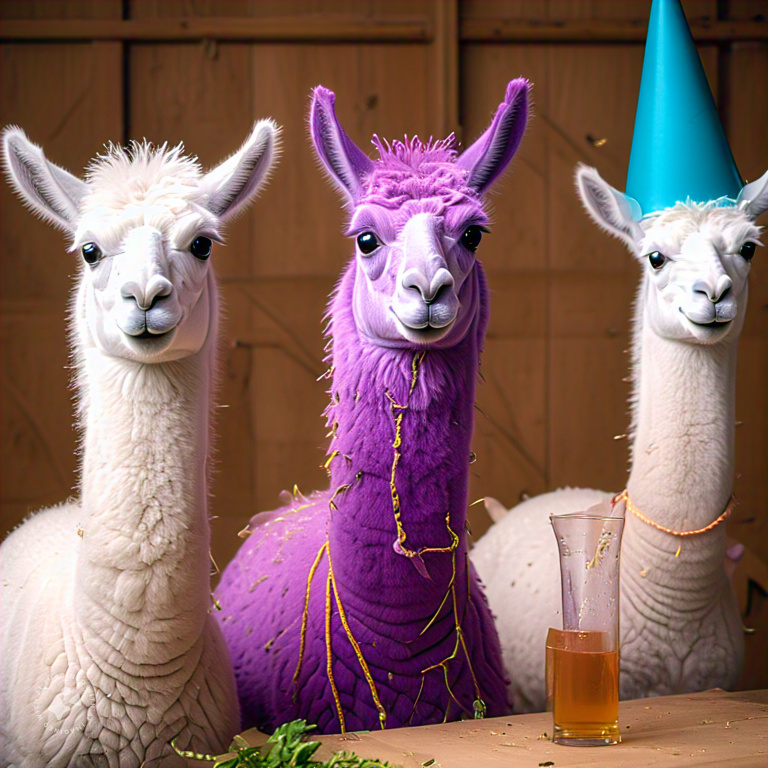

In [54]:
!curl -O https://raw.githubusercontent.com/meta-llama/llama-models/refs/heads/main/Llama_Repo.jpeg

from IPython.display import Image
Image("Llama_Repo.jpeg", width=256, height=256)


In [55]:
import base64
vision_model_id = "together/meta-llama/Llama-4-Scout-17B-16E-Instruct"

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        base64_string = base64.b64encode(image_file.read()).decode("utf-8")
        base64_url = f"data:image/png;base64,{base64_string}"
        return base64_url

### 3.2 Using Llama Stack Inference API for multimodal inference

In [56]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": encode_image("Llama_Repo.jpeg")
                    }
                },
                {
                    "type": "text",
                    "text": "How many different colors are those llamas? What are those colors?",
                }
            ]
        }
    ],
    model=vision_model_id,
    stream=False,
)

print(response.choices[0].message.content)

INFO:httpx:HTTP Request: POST http://0.0.0.0:8321/v1/chat/completions "HTTP/1.1 200 OK"


The image features three llamas, each with a distinct color. The colors of the llamas are as follows:

*   One llama is white.
*   Another llama is purple.
*   The third llama is also white.

Therefore, there are two different colors present among the llamas: white and purple.
